# One-class Classification : Elliptical Envelope

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.covariance import MinCovDet
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
import pandas as pd

In [49]:
#Default hyperparameters#
CONTAMINATION = 0.1
SUPPORT_FRACTION = 1
#########################

### Elliptical Envelope Classifier : Algorithm

In [50]:
class EllipticEnvelopeClassifier:
    
    def __init__(self,contamination=CONTAMINATION,support_fraction = SUPPORT_FRACTION):
        self.mcd = MinCovDet(support_fraction=support_fraction)
        self.contamination = contamination

    def fit(self, X):
        self.mcd.fit(X)
        self.offset_ = np.percentile(-self.mcd.dist_, 100.0 * self.contamination)
        return self
    
    def mahalanobis(self, X):
        dist = pairwise_distances(X, self.mcd.location_[np.newaxis, :], metric="mahalanobis", VI=self.mcd.get_precision())
        return np.reshape(dist, (len(X),)) ** 2

    def predict(self, X):
        negative_mahal_dist = -self.mahalanobis(X)
        values = negative_mahal_dist - self.offset_
        outlier_val = np.full(values.shape[0], 1, dtype=int)
        outlier_val[values >= 0] = 0

        return outlier_val

### Evaluation Function

In [51]:
def evaluate(csv_file_path,ycolname):
    df = pd.read_csv(csv_file_path)
    X = df.drop(columns=[ycolname]).values
    Y = df[ycolname].values
    trainX, testX, trainy, testy = train_test_split(X, Y, test_size=0.2, random_state=42)
    # define outlier detection model
    # model = EllipticEnvelopeClassifier(contamination=0.05)
    model = EllipticEnvelopeClassifier(contamination=CONTAMINATION,support_fraction=SUPPORT_FRACTION)
    # fit on majority class
    trainX = trainX[trainy==0]
    model.fit(trainX)
    # detect outliers in the test set
    testy_pred = model.predict(testX)
    cm = confusion_matrix(testy>0, testy_pred>0)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Inlier','Outlier'])
    disp.plot()
    print("Outlier predictions:",np.sum(testy_pred>0))
    print("Inlier predictions:",np.sum(testy_pred<=0))
    print("Outlier actuals:",np.sum(testy>0))
    print("Inlier actuals:",np.sum(testy<=0))
    print(f'Accuracy score: {accuracy_score(testy>0, testy_pred>0) :>.3%}')
    print(f'F1 score: {f1_score(testy>0, testy_pred>0) :>.3}')
    plt.show()

### Evaluation on Dataset 1 : 'http.csv'

Outlier predictions: 569
Inlier predictions: 112931
Outlier actuals: 445
Inlier actuals: 113055
Accuracy score: 99.891%
F1 score: 0.878


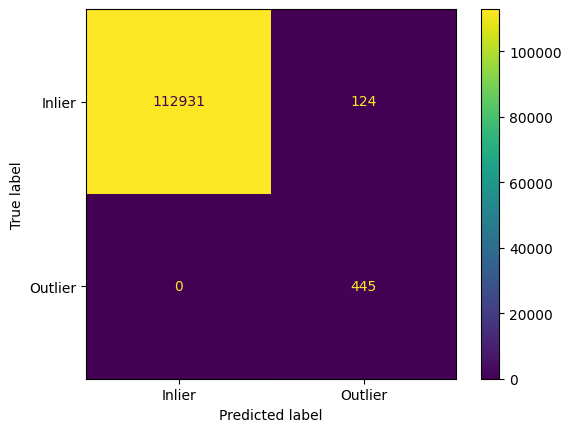

In [52]:
#Application-specific hyperparameters#
CONTAMINATION = 1e-3
SUPPORT_FRACTION = 1
######################################

evaluate('http.csv','attack')

### Evaluation on Dataset 2 : 'cancer.csv'

Outlier predictions: 46
Inlier predictions: 68
Outlier actuals: 43
Inlier actuals: 71
Accuracy score: 90.351%
F1 score: 0.876


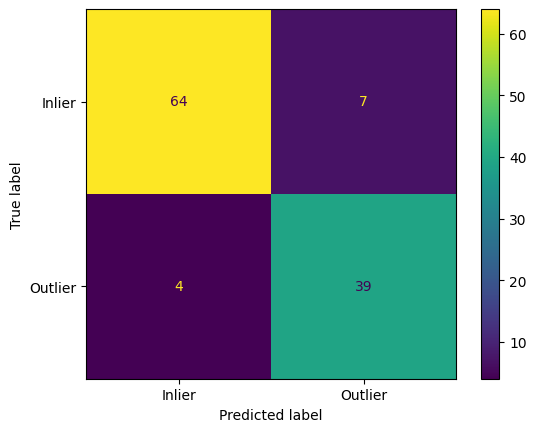

In [57]:
#Application-specific hyperparameters#
CONTAMINATION = 0.1
SUPPORT_FRACTION = 1
######################################

evaluate('cancer.csv','diagnosis')